<a href="https://colab.research.google.com/github/ChristelSirocchi/medical-informed-ML/blob/main/PIMA_Domain_knowledge%2BML_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/erdogant/bnlearn

  Cloning https://github.com/erdogant/bnlearn to /tmp/pip-req-build-891vlygy
  Running command git clone --filter=blob:none --quiet https://github.com/erdogant/bnlearn /tmp/pip-req-build-891vlygy
  Resolved https://github.com/erdogant/bnlearn to commit f5febaf6623d7595b7648bedb24833edc91b771a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 M

In [3]:
import bnlearn as bn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t
import math

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import binary_cross_entropy

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree

In [7]:
pd.options.mode.chained_assignment = None

In [8]:
# function to compute performance metrics
def get_results(y_pred, y_test):
    a   = accuracy_score(y_test, y_pred)
    ba  = balanced_accuracy_score(y_test, y_pred)
    p   = precision_score(y_test, y_pred)
    r   = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return [a, ba, p, r, f1, roc, mcc]

In [9]:
# function to correct standard deviation using Nadeau and Bengio's approach.
def corrected_std(differences, n_train, n_test):
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

# function to compute right-tailed paired t-test with corrected variance.
def compute_corrected_ttest(differences, df, n_train, n_test):
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [28]:
# function to generate summary table
def get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test):
  res = pd.DataFrame(index = scores_ml.columns, columns = ["ML_mean","ML_std","KB-ML_mean","KB-ML_std"])
  res["ML_mean"] = scores_ml.mean().round(3)
  res["ML_std"] = scores_ml.std().round(3)
  res["KB-ML_mean"] = scores_kbml.mean().round(3)
  res["KB-ML_std"] = scores_kbml.std().round(3)
  #res["p-value"] = np.nan
  res["corr_p-value"] = np.nan
  for c in res.index:
    difference = scores_ml[c].values - scores_kbml[c].values
    # uncorrected paired t-test p-value
    t_stat_uncorrected = np.mean(difference) / np.sqrt(np.var(difference, ddof=1) / n)
    p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), n_1)
    #res.loc[c,"p-value"] = p_val_uncorrected.round(4)
    # corrected paired t-test p-value
    t_stat, p_val = compute_corrected_ttest(difference, n_1, n_train, n_test)
    res.loc[c,"corr_p-value"] = p_val.round(3)
  return res

**Preprocessing**

In [11]:
# load the dataset
dataset = pd.read_csv('drive/MyDrive/Colab_Notebooks/pima-indians-diabetes.csv', delimiter=',')

In [12]:
# DOMAIN KNOWLEDGE : NON-ZERO COLUMNS
not_zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# DOMAIN KNOWLEDGE : INTERVALS
bin_labels = ['L', 'M', 'H', "VH"]
cat_bins = {
  "Pregnancies" : [-1,0, 5, float('inf')],
  "Age" : [20, 35, 45, float('inf')],
  "Glucose" : [0, 95, 150, float('inf')], # "Glucose" : [0, 95, 126, 150, float('inf')],
  "BloodPressure" : [0, 70, 100, float('inf')],
  "SkinThickness" : [0, 21, 40, float('inf')],
  "Insulin" : [0, 140, 200, float('inf')],
  "BMI" : [0, 23, 30, float('inf')],
  "DiabetesPedigreeFunction" : [0, 0.4, 0.8, float('inf')]
}

# DOMAIN KNOWLEDGE : Bayesian graph
edges = [("BMI", "SkinThickness"),
         ("Pregnancies", "Glucose"), ("Age", "Glucose"), ("DiabetesPedigreeFunction", "Glucose"), #("BMI", "Glucose"),
         ("Pregnancies", "Insulin"), ("Age", "Insulin"), ("DiabetesPedigreeFunction", "Insulin"), #("BMI", "Insulin"),
         ("Pregnancies", "BloodPressure"), ("Age", "BloodPressure"), ("DiabetesPedigreeFunction", "BloodPressure"), #("BMI", "BloodPressure")
         ]

# DOMAIN KNOWLEDGE : RULES
rule1 = (dataset["Glucose"]<=100) & (dataset["BMI"]<=25)
rule2 = (dataset["Glucose"]>=126) & (dataset["BMI"]>=30)

# DOMAIN KNOWLEDGE : FORMULAS
# Insulin Sensitivity
# dataset['Insulin_Sensitivity'] = dataset['Glucose'] / (dataset['Insulin'] * dataset['BMI'])
# Insulin Resistance Index
# dataset['Insulin_Resistance_Index'] = dataset['Insulin'] * dataset['Glucose'] / dataset['BMI']

In [13]:
# dataset of numerical features
dataset_num = dataset.copy()
# fill null values with median values
dataset_num.loc[:, not_zero_columns] = dataset_num[not_zero_columns].replace(0, np.nan)
for col in not_zero_columns:
  dataset_num[col] = dataset_num[col].fillna(dataset_num[col].median())
# set features and target for learning
Xml = dataset_num.values[:,:8]
y = dataset_num.values[:,8]

In [14]:
# dataset of categorical features
dataset_cat = dataset_num.copy()
# discretise
for (key, value) in cat_bins.items():
  dataset_cat[key] = pd.cut(dataset_cat[key], bins = value, labels = bin_labels[:len(value)-1])
# one-hot encoding
dataset_cat = pd.get_dummies(dataset_cat, drop_first = True)
# set features and target for learning
Xkb = dataset_cat.values[:,1:]

In [15]:
# set splits
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
splits = list(rskf.split(Xml, y))

# set parameters
n_train = len(list(splits[0][0]))
n_test = len(list(splits[0][1]))
n = len(splits)
n_1 = n - 1

**1.1 Data Pre-processing : Discretization**

In [33]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(Xml, y))
# save scores
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])

for r, (train_index, test_index) in enumerate(splits):
  # train ML model
  ml_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xml[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xml[test_index,:])
  scores_ml.loc[r] = get_results(y_pred, y[test_index])
  # train KB-ML model
  ml_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xkb[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xkb[test_index,:])
  scores_kbml.loc[r] = get_results(y_pred, y[test_index])

get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.712,0.045,0.688,0.047,0.110
BA,0.701,0.048,0.675,0.051,0.114
P,0.579,0.060,0.549,0.063,0.126
R,0.664,0.087,0.632,0.099,0.219
F1,0.692,0.047,0.666,0.049,0.105
ROC,0.701,0.048,0.675,0.051,0.114
MCC,0.393,0.093,0.343,0.098,0.112


In [26]:
#tree_rules = export_text(rf_modeln, feature_names=list(dataset_num.columns[:8]))
#print(tree_rules)

In [ ]:
#tree_rules = export_text(rf_modelc, feature_names=list(dataset_cat.columns[1:]))
#print(tree_rules)

**1.2 Data pre-processing : Missing data imputation**

In [38]:
# function to impute missing data with most frequent value
def impute_mode(train, test, to_impute):
  mode_dict = dict(test[to_impute].mode().T[0])
  return train.fillna(mode_dict), test.fillna(mode_dict)

# function to impute missing data with Bayesian imputation
def impute_bayes(train, test, to_impute, evidence):
  DAG = bn.make_DAG(edges, verbose = 0)
  DAG = bn.parameter_learning.fit(DAG, train.copy(), methodtype = 'maximumlikelihood', verbose = 0)
  train = impute_missing_data(train, train, to_impute, evidence, DAG)
  test = impute_missing_data(test, train, to_impute, evidence, DAG)
  return train, test

def impute_missing_data(df, train, to_impute, evidence, DAG):
    for var_to_impute in to_impute:
        qmode = train[var_to_impute].mode()[0]
        for index, row in df[df[var_to_impute].isna()].iterrows():
            # predict missing value
            q = bn.inference.fit(DAG, variables=[var_to_impute], evidence=dict(row[evidence]), verbose = 0).df
            qmode = train[var_to_impute].mode()[0]
            qmax = list(q[q["p"]==q["p"].max()][var_to_impute])
            # handle cases where more than one outcome have same probability
            if (len(qmax)==1):
              imp = qmax[0]
            # if one of these outcomes is the mode, choose the mode
            elif (len(qmax)>1) & (qmode in qmax):
              imp = qmode
            # otherwise, default to medium value
            else:
              imp = "M"
            df.loc[index, var_to_impute] = imp
    return df

In [39]:
# dataset of categorical features
dataset_cat_na = dataset.copy()
# fill null values
dataset_cat_na.loc[:, not_zero_columns] = dataset_cat_na[not_zero_columns].replace(0, np.nan)
# discretise
for (key, value) in cat_bins.items():
  dataset_cat_na[key] = pd.cut(dataset_cat_na[key], bins = value, labels = bin_labels[:len(value)-1])
# remove unimputable samples
no_na = ["Pregnancies", "Age", "BMI", "DiabetesPedigreeFunction"]
dataset_cat_na = dataset_cat_na[~dataset_cat_na[no_na].isnull().any(axis=1)]
# features to impute
to_impute = list(dataset_cat_na.columns[dataset_cat_na.isna().any()])
to_impute

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin']

In [40]:
# set features and target for learning
Xf = dataset_cat_na.drop(columns = "Outcome")
yf = dataset_cat_na.values[:,-1].astype(int)

In [41]:
# define Bayesian network
edges = [("BMI", "SkinThickness"),
         ("Pregnancies", "Glucose"), ("Age", "Glucose"), ("DiabetesPedigreeFunction", "Glucose"), #("BMI", "Glucose"),
         ("Pregnancies", "Insulin"), ("Age", "Insulin"), ("DiabetesPedigreeFunction", "Insulin"), #("BMI", "Insulin"),
         ("Pregnancies", "BloodPressure"), ("Age", "BloodPressure"), ("DiabetesPedigreeFunction", "BloodPressure"), #("BMI", "BloodPressure")
         ]
# feature that constitute evidence for prediction
evidence = list(set([a for (a,b) in edges]))

In [43]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(Xml[Xf.index,:], y[Xf.index]))

# save scores
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])

for r, (train_index, test_index) in enumerate(splits):
  train = Xf.iloc[train_index]
  test = Xf.iloc[test_index]
  # impute with mode & train ML model
  train_m, test_m = impute_mode(train, test, to_impute)
  ml_model = RandomForestClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(pd.get_dummies(train_m, drop_first = True).values, yf[train_index])
  y_pred = ml_model.predict(pd.get_dummies(test_m, drop_first = True).values)
  scores_ml.loc[r] = get_results(y_pred, yf[test_index])
  # impute Bayesian & train KB-ML model
  train_b, test_b = impute_bayes(train, test, to_impute, evidence)
  ml_model = RandomForestClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(pd.get_dummies(train_b, drop_first = True).values, yf[train_index])
  y_pred = ml_model.predict(pd.get_dummies(test_b, drop_first = True).values)
  scores_kbml.loc[r] = get_results(y_pred, yf[test_index])

get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.713,0.048,0.720,0.049,0.248
BA,0.696,0.051,0.702,0.053,0.309
P,0.589,0.075,0.598,0.074,0.260
R,0.639,0.095,0.641,0.093,0.472
F1,0.691,0.051,0.697,0.052,0.276
ROC,0.696,0.051,0.702,0.053,0.309
MCC,0.389,0.102,0.400,0.105,0.299


**2.1 Feature Engineering : Including/Excluding features**



In [44]:
# compute correlations with target
#for c in dataset_num.columns[:8]:
#  print(c +  " : ")
#  print(stats.pearsonr(dataset_num[c], dataset_num["Outcome"]))

In [45]:
# set features and target for learning
Xml = dataset_num[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].values
Xkb = dataset_num[['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].values #SkinThickness removed
y = dataset_num['Outcome'].values

In [53]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(Xml, y))

# save scores
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])

for r, (train_index, test_index) in enumerate(splits):
  # train ML model
  ml_model = RandomForestClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xml[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xml[test_index,:])
  scores_ml.loc[r] = get_results(y_pred, y[test_index])
  # train KB-ML model
  ml_model = RandomForestClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xkb[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xkb[test_index,:])
  scores_kbml.loc[r] = get_results(y_pred, y[test_index])

get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.762,0.044,0.770,0.043,0.192
BA,0.743,0.050,0.752,0.051,0.193
P,0.656,0.064,0.666,0.062,0.219
R,0.680,0.093,0.693,0.095,0.245
F1,0.740,0.048,0.748,0.048,0.191
ROC,0.743,0.050,0.752,0.051,0.193
MCC,0.484,0.096,0.501,0.096,0.191


**2.2 Feature Engineering : Computing new features**

In [74]:
# dataset of numerical features
dataset_nv = dataset.copy()
# fill null values
dataset_nv.loc[:, not_zero_columns] = dataset_nv[not_zero_columns].replace(0, np.nan)
# do not consider samples with null values in relevant feature
dataset_nv = dataset_nv[dataset_nv[['Age', 'Insulin', 'BMI']].notnull().all(axis = 1)]
# impute remaining samples
dataset_nv = dataset_nv.fillna(dataset_nv.median())

In [75]:
# G I ratio
# dataset_nv['Glucose_Insulin_Ratio'] = dataset_nv['Glucose'] / dataset_nv['Insulin']

# Insulin Sensitivity
# dataset_nv['Insulin_Sensitivity'] = dataset_nv['Glucose'] / (dataset_nv['Insulin'] * dataset_nv['BMI'])

# Insulin Resistance Index
# dataset_nv['Insulin_Resistance'] = dataset_nv['Insulin'] * dataset_nv['Glucose'] / dataset_nv['BMI']
dataset_nv['Insulin_Resistance'] = 0.222 - 0.00333*dataset_nv['BMI'] - 0.0000779* dataset_nv['Insulin'] - 0.000422* dataset_nv['Age']

In [76]:
# set features and target
Xkb = dataset_nv[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction', 'Insulin_Resistance']].values
Xml = dataset_nv[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].values
y = dataset_nv['Outcome'].values

In [81]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(Xml, y))

# save scores
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])

for r, (train_index, test_index) in enumerate(splits):
  # train ML model
  ml_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xml[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xml[test_index,:])
  scores_ml.loc[r] = get_results(y_pred, y[test_index])
  # train KB-ML model
  ml_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xkb[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xkb[test_index,:])
  scores_kbml.loc[r] = get_results(y_pred, y[test_index])

get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.721,0.074,0.719,0.067,0.479
BA,0.701,0.080,0.702,0.074,0.486
P,0.579,0.108,0.573,0.098,0.437
R,0.642,0.132,0.650,0.131,0.428
F1,0.692,0.078,0.692,0.072,0.493
ROC,0.701,0.080,0.702,0.074,0.486
MCC,0.396,0.156,0.396,0.145,0.496


<BarContainer object of 6 artists>

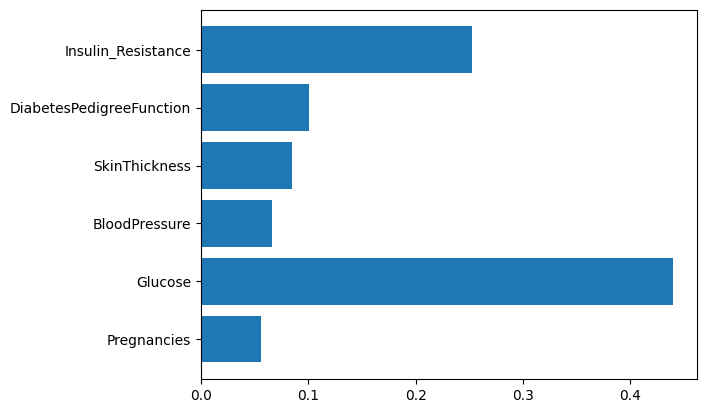

In [ ]:
plt.barh(width = ml_model.feature_importances_, y = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction', 'Insulin_Resistance'])

**3.1 Learning : Loss Function**

In [ ]:
# define neural network class
class PimaClassifier_ML(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.hidden1 = nn.Linear(n_feat, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

    def fit(self, X, y, epochs=24, batch_size=20, lr=0.01):

        # Convert to PyTorch tensors
        X_train = torch.tensor(X, dtype=torch.float32)
        y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

        # Define the loss function and optimizer
        criterion = nn.BCELoss()#nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if epoch % 5 == 0:
              print(f'Finished epoch {epoch}, latest loss {loss}')

    def predict(self, X):
        X_test = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
          y_pred = model(X_test)
        return y_pred.flatten().numpy().round().astype(int)

In [91]:
# define neural network class
class PimaClassifier_KBML(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.hidden1 = nn.Linear(n_feat, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

    def fit(self, X_train, y_train, mask, epochs=24, batch_size=20, lr=0.01):
        loss_fn_kb = CustomLoss()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        # convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        mask = torch.tensor(mask).reshape(-1,1)
        for epoch in range(epochs):
          for i in range(0, len(X_train), batch_size):
              X_batch = X_train[i:i+batch_size]
              y_batch = y_train[i:i+batch_size]
              mask_batch = mask[i:i+batch_size]
              y_pred = model(X_batch)
              loss = loss_fn_kb(y_pred, y_batch, mask_batch, 3)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if epoch % 5 == 0:
            print(f'Finished epoch {epoch}, latest loss {loss}')

    def predict(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32)
        with torch.no_grad():
          y_pred = model(X_test)
        return y_pred.flatten().numpy()

In [92]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, target, mask, factor):
        criterion = nn.BCELoss()
        loss = criterion(output, target)
        high_cost = factor*binary_cross_entropy(output, target, weight = mask.float())
        return loss + high_cost

In [117]:
def compute_coherence(y_test, y_rule, y_pred):
  if sum(y_test == y_rule) != 0:
    return sum((y_test == y_rule) & (y_rule == y_pred.round())) / sum(y_test == y_rule)
  else:
    return np.nan

In [93]:
# split the dataset into features (X) and target (y)
X = dataset_num.iloc[:,:8].values
y = dataset_num.iloc[:, 8].values

# compute predicted outcome based on rule
dataset_rules = dataset_num.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0

# identify samples correctly identified by the rules (which will be assigned heavier training weights)
mask = (dataset_rules["Rules"] == dataset_rules["Outcome"]).values

In [108]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(X, y))

# save results
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])

for r, (train_index, test_index) in enumerate(splits):
  # scale data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X[train_index,:])
  X_test = scaler.transform(X[test_index,:])
  mask_train = mask[train_index]
  y_train = y[train_index]
  y_test = y[test_index]
  y_rule = dataset_rules.loc[test_index,"Rules"].values

  # train ML model
  model = PimaClassifier_ML(X.shape[1])
  print("ML Iteration ", r)
  model.fit(X_train, y_train, epochs=24)
  y_pred = model.predict(X_test)
  # save scores with coherence
  scores_ml.loc[r] = get_results(y_pred.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred.round())]

  # train KB-ML model
  model = PimaClassifier_KBML(X.shape[1])
  print("KB-ML Iteration ", r)
  model.fit(X_train, y_train, mask_train, epochs=24)
  y_pred = model.predict(X_test)
  # save scores with coherence
  scores_kbml.loc[r] = get_results(y_pred.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred.round())]

ML Iteration  0
Finished epoch 0, latest loss 0.7240874767303467
Finished epoch 5, latest loss 0.5037094950675964
Finished epoch 10, latest loss 0.44560205936431885
Finished epoch 15, latest loss 0.41278916597366333
Finished epoch 20, latest loss 0.38898709416389465
KB-ML Iteration  0
Finished epoch 0, latest loss 1.371707558631897
Finished epoch 5, latest loss 1.044484257698059
Finished epoch 10, latest loss 0.874362587928772
Finished epoch 15, latest loss 0.7688190937042236
Finished epoch 20, latest loss 0.659800112247467
ML Iteration  1
Finished epoch 0, latest loss 0.6927128434181213
Finished epoch 5, latest loss 0.4128277003765106
Finished epoch 10, latest loss 0.30398136377334595
Finished epoch 15, latest loss 0.27260053157806396
Finished epoch 20, latest loss 0.26610076427459717
KB-ML Iteration  1
Finished epoch 0, latest loss 1.366471767425537
Finished epoch 5, latest loss 0.7249414920806885
Finished epoch 10, latest loss 0.545172929763794
Finished epoch 15, latest loss 0.47260

In [109]:
get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.764,0.042,0.754,0.045,0.174
BA,0.725,0.051,0.747,0.050,0.038
P,0.690,0.073,0.632,0.062,0.001
R,0.597,0.099,0.721,0.088,0.000
F1,0.730,0.051,0.737,0.048,0.288
ROC,0.725,0.051,0.747,0.050,0.038
MCC,0.469,0.099,0.482,0.097,0.287
Rule,0.905,0.067,0.974,0.034,0.000


**3.2 Learning : Architecture**

In [83]:
Xml = dataset_num.values[:,:8]
y = dataset_num.values[:,8]

In [84]:
# split data according to domain rules
def split_data_rules(data):
  subset1 = data[(data["Glucose"]<=100) & (data["BMI"]<=25)]
  subset2 = data[((data["Glucose"]<=100) & (data["BMI"]> 25)) | ((data["Glucose"]> 100) & (data["Glucose"]<126)) | (data["Glucose"]>=126) & (data["BMI"]< 30)]
  subset3 = data[(data["Glucose"]>=126) & (data["BMI"]>=30)]
  return subset1, subset2, subset3

In [89]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(Xml, y))

# save scores
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC"])

for r, (train_index, test_index) in enumerate(splits):
  # train ML model
  ml_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(Xml[train_index,:], y[train_index])
  y_pred = ml_model.predict(Xml[test_index,:])
  scores_ml.loc[r] = get_results(y_pred, y[test_index])
  # train KB-ML model
  # fit
  data_train =  dataset_num.iloc[train_index]
  subset1, subset2, subset3 = split_data_rules(data_train)
  rf_model2 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(subset2.values[:,:8], subset2.values[:,8])
  rf_model3 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight ="balanced").fit(subset3.values[:,:8], subset3.values[:,8])
  data_test = dataset_num.iloc[test_index]
  # predict
  subtest1, subtest2, subtest3 = split_data_rules(data_test)
  data_test["Pred"] = 0
  data_test.loc[subtest2.index, "Pred"] = rf_model2.predict(subtest2.values[:,:8])
  data_test.loc[subtest3.index, "Pred"] = rf_model3.predict(subtest3.values[:,:8])
  # save results
  scores_kbml.loc[r] = get_results(data_test["Pred"].values, data_test["Outcome"].values)

get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.713,0.045,0.695,0.054,0.173
BA,0.703,0.047,0.689,0.056,0.248
P,0.581,0.061,0.556,0.070,0.163
R,0.668,0.083,0.670,0.091,0.479
F1,0.694,0.046,0.678,0.055,0.203
ROC,0.703,0.047,0.689,0.056,0.248
MCC,0.396,0.092,0.368,0.109,0.231


**4.1 Output evaluation : Learner ensemble**

In [155]:
# compute predicted outcome based on rule
dataset_rules = dataset_num.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0
dataset_rules["Rules"] = dataset_rules["Rules"].fillna(0.5)

In [156]:
# split the dataset into features (X) and target (y)
X = dataset_num.iloc[:,:8].values
y = dataset_num.iloc[:, 8].values

In [157]:
# set parameters for both experiments
n_epochs = 24
batch_size = 20

In [158]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(X, y))

# save results
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])

for r, (train_index, test_index) in enumerate(splits):
  # scale data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X[train_index,:])
  X_test = scaler.transform(X[test_index,:])
  y_train = y[train_index]
  y_test = y[test_index]
  y_rule = dataset_rules.loc[test_index,"Rules"].values

  # train ML model
  model = PimaClassifier_ML(X.shape[1])
  print("ML Iteration ", r)
  model.fit(X_train, y_train, epochs=24)
  y_pred = model.predict(X_test)
  # save scores with coherence
  scores_ml.loc[r] = get_results(y_pred.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred.round())]

  # compute KB-ML scores
  y_pred2 = (y_pred + y_rule >= 1)*1 # ensemble with rules
  scores_kbml.loc[r] = get_results(y_pred2.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred2.round())]

ML Iteration  0
Finished epoch 0, latest loss 0.6828203797340393
Finished epoch 5, latest loss 0.49927064776420593
Finished epoch 10, latest loss 0.3806665241718292
Finished epoch 15, latest loss 0.3464010953903198
Finished epoch 20, latest loss 0.33739906549453735
ML Iteration  1
Finished epoch 0, latest loss 0.6663191318511963
Finished epoch 5, latest loss 0.5893274545669556
Finished epoch 10, latest loss 0.4400014877319336
Finished epoch 15, latest loss 0.3951692581176758
Finished epoch 20, latest loss 0.3768327832221985
ML Iteration  2
Finished epoch 0, latest loss 0.7018004059791565
Finished epoch 5, latest loss 0.5045767426490784
Finished epoch 10, latest loss 0.4125644564628601
Finished epoch 15, latest loss 0.37544888257980347
Finished epoch 20, latest loss 0.3561100363731384
ML Iteration  3
Finished epoch 0, latest loss 0.6428980231285095
Finished epoch 5, latest loss 0.40849849581718445
Finished epoch 10, latest loss 0.3311445415019989
Finished epoch 15, latest loss 0.3028104

In [148]:
get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.765,0.043,0.759,0.043,0.251
BA,0.726,0.053,0.738,0.052,0.095
P,0.690,0.071,0.653,0.062,0.006
R,0.598,0.103,0.668,0.101,0.000
F1,0.731,0.052,0.735,0.048,0.312
ROC,0.726,0.053,0.738,0.052,0.095
MCC,0.470,0.101,0.475,0.098,0.393
Rule,0.906,0.064,1.000,0.000,0.000


**Data efficiency experiment**

In [159]:
# data efficiency experiment
ml_total = scores_ml.copy()
kbml_total = scores_kbml.copy()

In [163]:
# subsample data
dataset_sample = dataset_rules.sample(n=200, random_state = 4)
# split the dataset into features (X) and target (y)
Xs = dataset_sample.iloc[:,:8].values
ys = dataset_sample.iloc[:, 8].values

In [164]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(Xs, ys))

# save results
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])

for r, (train_index, test_index) in enumerate(splits):
  # scale data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X[train_index,:])
  X_test = scaler.transform(X[test_index,:])
  y_train = y[train_index]
  y_test = y[test_index]
  y_rule = dataset_rules.loc[test_index,"Rules"].values

  # train ML model
  model = PimaClassifier_ML(X.shape[1])
  print("ML Iteration ", r)
  model.fit(X_train, y_train, epochs=24)
  y_pred = model.predict(X_test)
  # save scores with coherence
  scores_ml.loc[r] = get_results(y_pred.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred.round())]

  # train KB-ML model
  model = PimaClassifier_KBML(X.shape[1])
  print("KB-ML Iteration ", r)
  model.fit(X_train, y_train, mask_train, epochs=24)
  y_pred = model.predict(X_test)
  # save scores with coherence
  scores_kbml.loc[r] = get_results(y_pred.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred.round())]

ML Iteration  0
Finished epoch 0, latest loss 0.7085170149803162
Finished epoch 5, latest loss 0.6834611892700195
Finished epoch 10, latest loss 0.6528851985931396
Finished epoch 15, latest loss 0.6121578812599182
Finished epoch 20, latest loss 0.5677995085716248
KB-ML Iteration  0
Finished epoch 0, latest loss 1.7325862646102905
Finished epoch 5, latest loss 1.577951431274414
Finished epoch 10, latest loss 1.3458919525146484
Finished epoch 15, latest loss 1.089974284172058
Finished epoch 20, latest loss 0.9262324571609497
ML Iteration  1
Finished epoch 0, latest loss 0.7330466508865356
Finished epoch 5, latest loss 0.7219682931900024
Finished epoch 10, latest loss 0.6858121156692505
Finished epoch 15, latest loss 0.6169297099113464
Finished epoch 20, latest loss 0.540364146232605
KB-ML Iteration  1
Finished epoch 0, latest loss 1.6829259395599365
Finished epoch 5, latest loss 1.5776159763336182
Finished epoch 10, latest loss 1.4303107261657715
Finished epoch 15, latest loss 1.20348095

In [165]:
res1 = get_results_table(ml_total, kbml_total, n_1, n_train, n_test).drop(columns = "corr_p-value")
res1.columns = [s + "_total" for s in res1.columns]
res2 = get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test).drop(columns = "corr_p-value")
results = pd.concat([res1,res2], axis=1)
for c in results.index:
  results.loc[c,"p-value_ml"] = stats.ttest_ind(ml_total[c], scores_ml[c])[1].round(3)
  results.loc[c,"p-value_kbml"] = stats.ttest_ind(kbml_total[c], scores_kbml[c])[1].round(3)
results

,ML_mean_total,ML_std_total,KB-ML_mean_total,KB-ML_std_total,ML_mean,ML_std,KB-ML_mean,KB-ML_std,p-value_ml,p-value_kbml
A,0.766,0.046,0.759,0.045,0.715,0.097,0.718,0.112,0.000,0.001
BA,0.727,0.056,0.738,0.054,0.678,0.104,0.735,0.102,0.000,0.775
P,0.692,0.077,0.653,0.063,0.651,0.228,0.600,0.159,0.090,0.002
R,0.599,0.106,0.668,0.103,0.523,0.216,0.793,0.161,0.002,0.000
F1,0.732,0.055,0.736,0.051,0.666,0.119,0.704,0.122,0.000,0.018
ROC,0.727,0.056,0.738,0.054,0.678,0.104,0.735,0.102,0.000,0.775
MCC,0.473,0.108,0.476,0.103,0.377,0.213,0.458,0.201,0.000,0.424
Rule,0.906,0.072,1.000,0.000,0.840,0.190,0.969,0.091,0.001,0.001


**4.2 Output evaluation : Learner Concatenation**

In [176]:
# compute predicted outcome based on rule
dataset_rules_na = dataset_num.copy()

#expected outcome based on rules
dataset_rules_na["Rules"] = np.nan
dataset_rules_na.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules_na["Glucose"] >= 126), "Rules"] = 1
dataset_rules_na.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules_na["Glucose"] <= 100), "Rules"] = 0

In [177]:
# set parameters for both experiments
n_epochs = 24
batch_size = 20

In [178]:
# split the dataset into features (X) and target (y)
X = dataset_num.iloc[:,:8].values
y = dataset_num.iloc[:, 8].values

In [181]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(X, y))

# save results
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "Rule"])
filtered = []

for r, (train_index, test_index) in enumerate(splits):
  # scale data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X[train_index,:])
  X_test = scaler.transform(X[test_index,:])
  y_train = y[train_index]
  y_test = y[test_index]
  y_rule = dataset_rules_na.loc[test_index,"Rules"].values

  # train ML model
  model = PimaClassifier_ML(X.shape[1])
  print("ML Iteration ", r)
  model.fit(X_train, y_train, epochs=24)
  y_pred = model.predict(X_test)
  # save scores with coherence
  scores_ml.loc[r] = get_results(y_pred.round(), y_test) + [compute_coherence(y_test, y_rule, y_pred.round())]

  # compute KB-ML scores
  filter = np.isnan(y_rule) | (y_rule == np.round(y_pred))
  scores_kbml.loc[r] = get_results(y_pred.round()[filter], y_test[filter]) + [compute_coherence(y_test[filter], y_rule[filter], y_pred.round()[filter])]

ML Iteration  0
Finished epoch 0, latest loss 0.7206993699073792
Finished epoch 5, latest loss 0.5034388899803162
Finished epoch 10, latest loss 0.42171457409858704
Finished epoch 15, latest loss 0.37729281187057495
Finished epoch 20, latest loss 0.35104671120643616
ML Iteration  1
Finished epoch 0, latest loss 0.6467330455780029
Finished epoch 5, latest loss 0.4195069372653961
Finished epoch 10, latest loss 0.3470398485660553
Finished epoch 15, latest loss 0.3247111141681671
Finished epoch 20, latest loss 0.31303170323371887
ML Iteration  2
Finished epoch 0, latest loss 0.6867997050285339
Finished epoch 5, latest loss 0.5134390592575073
Finished epoch 10, latest loss 0.4175151586532593
Finished epoch 15, latest loss 0.3868411183357239
Finished epoch 20, latest loss 0.37013834714889526
ML Iteration  3
Finished epoch 0, latest loss 0.7412666082382202
Finished epoch 5, latest loss 0.5908693671226501
Finished epoch 10, latest loss 0.37836161255836487
Finished epoch 15, latest loss 0.31294

In [182]:
get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,corr_p-value
A,0.767,0.043,0.779,0.044,0.006
BA,0.729,0.052,0.747,0.054,0.000
P,0.692,0.072,0.692,0.072,NaN
R,0.603,0.097,0.647,0.102,0.000
F1,0.734,0.052,0.750,0.051,0.001
ROC,0.729,0.052,0.747,0.054,0.000
MCC,0.475,0.101,0.504,0.102,0.001
Rule,0.909,0.063,1.000,0.000,0.000
